# About
To understand Competition Metric "DFL Event Detection AP", I prepared some simple label data and some predicted results.<br>
I hope this will help for you! <br>

## references
https://www.kaggle.com/code/hidebu/exploration-of-competition-metric-dfl-ap-jp-en

## Competition metric functions

In [2]:
# Google Colabで、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

#/root/.kaggleを作成して、apiを使えるようにする。
!sudo mkdir /root/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json /root/.kaggle/kaggle.json

# cdは!が使えない。マジックコマンド%で移動
%cd /content/drive/MyDrive/Competitions/DFL/
%ls -a

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
/content/drive/MyDrive/Competitions/DFL
.git/  .gitignore  input/  lib/  output/  src/  weight/  yolov7/


In [2]:
!pip install moviepy==1.0.3
!pip install transformers
# !pip install SoccerNet
# !pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 388 kB 4.1 MB/s 
     |████████████████████████████████| 26.9 MB 1.3 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=32dddc2a7f82cefd76d8ed872099c56d852899c518abf35745da43e689c34353
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
     |████████████████████████████████| 101 kB 503 kB/s 
     |████████████████████████████████| 6.6 MB 40.2 MB/s 
  Attemp

In [3]:
# ========================================
# library
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold, StratifiedGroupKFold
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel,AutoConfig
import transformers
from transformers import RobertaModel,RobertaTokenizer
from transformers import AlbertModel,AlbertTokenizer
from transformers import XLNetModel,XLNetTokenizer,XLNetConfig
from transformers import DebertaModel, DebertaTokenizer
from transformers import ElectraModel, ElectraTokenizer, ElectraForSequenceClassification
from transformers import BartModel,BertModel,BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import MPNetModel,MPNetTokenizer
from transformers import FunnelBaseModel,FunnelTokenizer,FunnelModel
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config
from transformers import T5EncoderModel,T5Tokenizer
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

import logging
import sys
from contextlib import contextmanager
import time
import random
from tqdm import tqdm
import os
import pickle
import gc

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, GroupKFold

# ========================================
# library
# ========================================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer
import logging
from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler

import sys
from contextlib import contextmanager
import time
import random
from tqdm import tqdm
import os

from PIL import Image
import cv2

import numpy as np
import pandas as pd
from pandas.testing import assert_index_equal
from typing import Dict, Tuple

from IPython.core.display import Video
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip, ffmpeg_movie_from_frames


# ========================================
# library
# ========================================
# import faiss
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.io import read_image

from torchvision.transforms import Resize, RandomHorizontalFlip, ColorJitter, Normalize, Compose, RandomResizedCrop, CenterCrop, ToTensor

from tqdm import tqdm
from PIL import Image
import joblib
from scipy.sparse import hstack, vstack, csc_matrix, csr_matrix
import editdistance
import networkx as nx
from transformers import BertConfig, BertModel, BertTokenizerFast

import sys
# sys.path.append('../input/timm045/')
# import timm

# import SoccerNet
# from SoccerNet.Downloader import SoccerNetDownloader

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# sn_track_base = '/tmp/tracking'

# !mkdir -p $sn_track_base
# !touch $sn_track_base/test.zip
# !touch $sn_track_base/challenge.zip


In [5]:
# ==================
# Constant
# ==================
ex = "00"
TRAIN_PATH = rf"/content/drive/MyDrive/Competitions/DFL/input/train.csv"
LOGGER_PATH = f"/content/drive/MyDrive/Competitions/DFL/output/ex{ex}.txt"
OOF_SAVE_PATH = f'/content/drive/MyDrive/Competitions/DFL/output/ex{ex}.npy'
INPUT_PATH = rf"/content/drive/MyDrive/Competitions/DFL/input/"
OUTPUT_PATH = rf"/content/drive/MyDrive/Competitions/DFL/output/"
WEIGHT_PATH = rf"/content/drive/MyDrive/Competitions/DFL/weight/"

os.makedirs(f'output', exist_ok=True)
MODEL_PATH_BASE = f"./output/ex{ex}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tolerances = {
    "challenge": [0.3, 0.4, 0.5, 0.6, 0.7],
    "play": [0.15, 0.20, 0.25, 0.30, 0.35],
    "throwin": [0.15, 0.20, 0.25, 0.30, 0.35],
}

In [6]:
# ===============
# Functions
# ===============            
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def setup_logger(out_file=None, stderr=True, stderr_level=logging.INFO, file_level=logging.DEBUG):
    LOGGER.handlers = []
    LOGGER.setLevel(min(stderr_level, file_level))

    if stderr:
        handler = logging.StreamHandler(sys.stderr)
        handler.setFormatter(FORMATTER)
        handler.setLevel(stderr_level)
        LOGGER.addHandler(handler)

    if out_file is not None:
        handler = logging.FileHandler(out_file)
        handler.setFormatter(FORMATTER)
        handler.setLevel(file_level)
        LOGGER.addHandler(handler)

    LOGGER.info("logger set up")
    return LOGGER

def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, 'time'].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.        
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x video evaluation group."""
    detections_sorted = detections.sort_values('score', ascending=False).dropna()

    is_matched = np.full_like(detections_sorted['event'], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(det.time - gt.time)
            if error < best_error and not gt in gts_matched:
                best_gt = gt
                best_error = error
            
        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]
    
    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]
    
    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]
    
    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches
    
    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, thresholds = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, float],
) -> float:

    assert_index_equal(solution.columns, pd.Index(['video_id', 'time', 'event']))
    assert_index_equal(submission.columns, pd.Index(['video_id', 'time', 'event', 'score']))

    # Extract scoring intervals.
    intervals = (
        solution
        .query("event in ['start', 'end']")
        .assign(interval=lambda x: x.groupby(['video_id', 'event']).cumcount())
        .pivot(index='interval', columns=['video_id', 'event'], values='time')
        .stack('video_id')
        .swaplevel()
        .sort_index()
        .loc[:, ['start', 'end']]
        .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
    )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts('event').to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    detections_filtered = []
    for (det_group, dets), (int_group, ints) in zip(
        detections.groupby('video_id'), intervals.groupby('video_id')
    ):
        assert det_group == int_group
        detections_filtered.append(filter_detections(dets, ints))
    detections_filtered = pd.concat(detections_filtered, ignore_index=True)

    # Create table of event-class x tolerance x video_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths['video_id'].unique()],
        columns=['event', 'tolerance', 'video_id'],
    )

    # Create match evaluation groups: event-class x tolerance x video_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)
    print(f"detection_matched: \n {detections_matched}")
    
    # Compute AP per event x tolerance group
    event_classes = ground_truths['event'].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby(['event', 'tolerance']).apply(
        lambda group: average_precision_score(
        group['matched'].to_numpy(),
                group['score'].to_numpy(),
                class_counts[group['event'].iat[0]],
            )
        )
    )
    print(f"ap_table: \n {ap_table}")

    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby('event').mean().mean()

    return mean_ap

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s')

LOGGER = logging.getLogger()
FORMATTER = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
setup_logger(out_file=LOGGER_PATH)

set_seed()

2022-08-15 13:58:05,834 - INFO - logger set up


In [7]:
# ===============
# Functions
# ===============            

def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"test_{row['index']}.mp4"
    ffmpeg_extract_subclip(
        f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        int(row['time']) - before, 
        int(row['time']) + after, 
        targetname=filename,
    )
    
    return Video(filename, width=800)

def convert(df):
    rets = []
    start_time = df["time"].values[0]
    end_time = df["time"].values[-1]
    video_id = df["video_id"].values[0]
    w_df = df.iloc[1:-1]
    
    events = w_df["event"].values
    times = w_df["time"].values
    
    for i in range(len(w_df)):
        
        duration = end_time - start_time
        
        digits = str(round(times[i] - int(times[i]), 2))[1:4]
        seconds = int(times[i]) % 60
        minutes = int(times[i] % 3600) % 60
        ret = {
            "video_id": video_id,
            "start_time": start_time,
            "end_time": end_time,
            "event_time": times[i],
            "duration": duration,
            "seconds": seconds,
            "minutes": minutes,
            "event": events[i],
            "digits": digits
        }
        rets.append(ret)
    return rets

def only_tolerance_(train):

    tolerances['No Event'] = [10**4+7]

    t_dic = {k:max(v) for k, v in tolerances.items()}

    train['diff'] = (train['event_time'] - train['start_time']).abs()
    train['event_tolerance'] = train['event'].map(t_dic)
    train = train.query('diff < event_tolerance').reset_index()


In [8]:
# ===============
# Transform, Dataset, Preprocess
# ===============    
class VideoTransform():
    """
    動画を画像にした画像ファイルの前処理クラス。学習時と推論時で異なる動作をします。
    動画を画像に分割しているため、分割された画像たちをまとめて前処理する点に注意してください。
    """

    def __init__(self, resize, crop_size, mean, std):
        self.data_transform = {
            'train': torchvision.transforms.Compose([
                # DataAugumentation()  # 今回は省略
                GroupResize(int(resize)),  # 画像をまとめてリサイズ　
                GroupCenterCrop(crop_size),  # 画像をまとめてセンタークロップ
                GroupToTensor(),  # データをPyTorchのテンソルに
                GroupImgNormalize(mean, std),  # データを標準化
                Stack()  # 複数画像をframes次元で結合させる
            ]),
            'val': torchvision.transforms.Compose([
                GroupResize(int(resize)),  # 画像をまとめてリサイズ　
                GroupCenterCrop(crop_size),  # 画像をまとめてセンタークロップ
                GroupToTensor(),  # データをPyTorchのテンソルに
                GroupImgNormalize(mean, std),  # データを標準化
                Stack()  # 複数画像をframes次元で結合させる
            ])
        }

    def __call__(self, img_group, phase):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img_group)

class GroupResize():
    ''' 画像をまとめてリスケールするクラス。
    画像の短い方の辺の長さがresizeに変換される。
    アスペクト比は保たれる。
    '''

    def __init__(self, resize, interpolation=Image.BILINEAR):
        '''リスケールする処理を用意'''
        self.rescaler = torchvision.transforms.Resize(resize, interpolation)

    def __call__(self, img_group):
        '''リスケールをimg_group(リスト)内の各imgに実施'''
        return [self.rescaler(img) for img in img_group]


class GroupCenterCrop():
    ''' 画像をまとめてセンタークロップするクラス。
        （crop_size, crop_size）の画像を切り出す。
    '''

    def __init__(self, crop_size):
        '''センタークロップする処理を用意'''
        self.ccrop = torchvision.transforms.CenterCrop(crop_size)

    def __call__(self, img_group):
        '''センタークロップをimg_group(リスト)内の各imgに実施'''
        return [self.ccrop(img) for img in img_group]


class GroupToTensor():
    ''' 画像をまとめてテンソル化するクラス。
    '''

    def __init__(self):
        '''テンソル化する処理を用意'''
        self.to_tensor = torchvision.transforms.ToTensor()

    def __call__(self, img_group):
        '''テンソル化をimg_group(リスト)内の各imgに実施
        0から1ではなく、0から255で扱うため、255をかけ算する。
        0から255で扱うのは、学習済みデータの形式に合わせるため
        '''

        return [self.to_tensor(img)*255 for img in img_group]


class GroupImgNormalize():
    ''' 画像をまとめて標準化するクラス。
    '''

    def __init__(self, mean, std):
        '''標準化する処理を用意'''
        self.normlize = torchvision.transforms.Normalize(mean, std)

    def __call__(self, img_group):
        '''標準化をimg_group(リスト)内の各imgに実施'''
        return [self.normlize(img) for img in img_group]


class Stack():
    ''' 画像を一つのテンソルにまとめるクラス。
    '''

    def __call__(self, img_group):
        '''img_groupはtorch.Size([3, 224, 224])を要素とするリスト
        '''
        ret = torch.cat([(x.flip(dims=[0])).unsqueeze(dim=0).to(DEVICE)
                         for x in img_group], dim=0)  # frames次元で結合
        # x.flip(dims=[0])は色チャネルをRGBからBGRへと順番を変えています（元の学習データがBGRであったため）
        # unsqueeze(dim=0)はあらたにframes用の次元を作成しています

        return ret

class VideoDataset(torch.utils.data.Dataset):
    """
    動画のDataset
    """

    def __init__(self, video_list, label_id_dict, num_segments, phase, transform, img_tmpl='image_{:05d}.jpg'):
        self.video_list = video_list  # 動画画像のフォルダへのパスリスト
        self.label_id_dict = label_id_dict  # ラベル名をidに変換する辞書型変数
        self.num_segments = num_segments  # 動画を何分割して使用するのかを決める
        self.phase = phase  # train or val
        self.transform = transform  # 前処理
        self.img_tmpl = img_tmpl  # 読み込みたい画像のファイル名のテンプレート

    def __len__(self):
        '''動画の数を返す'''
        return len(self.video_list)

    def __getitem__(self, index):
        '''
        前処理をした画像たちのデータとラベル、ラベルIDを取得
        '''
        imgs_transformed, label, label_id, dir_path = self.pull_item(index)
        return imgs_transformed, label, label_id, dir_path

    def pull_item(self, index):
        '''前処理をした画像たちのデータとラベル、ラベルIDを取得'''

        # 1. 画像たちをリストに読み込む
        dir_path = self.video_list[index]  # 画像が格納されたフォルダ
        indices = self._get_indices(dir_path)  # 読み込む画像idxを求める
        img_group = self._load_imgs(
            dir_path, self.img_tmpl, indices)  # リストに読み込む

        # 2. ラベルの取得し、idに変換する
        label = (dir_path.split('/')[3].split('/')[0])
        label_id = self.label_id_dict[label] # idを取得

        # 3. 前処理を実施
        imgs_transformed = self.transform(img_group, phase=self.phase)

        return imgs_transformed, label, label_id, dir_path

    def _load_imgs(self, dir_path, img_tmpl, indices):
        '''画像をまとめて読み込み、リスト化する関数'''
        img_group = []  # 画像を格納するリスト

        for idx in indices:
            # 画像のパスを取得
            file_path = os.path.join(dir_path, img_tmpl.format(idx))

            # 画像を読み込む
            img = Image.open(file_path).convert('RGB')

            # リストに追加
            img_group.append(img)
        return img_group

    def _get_indices(self, dir_path):
        """
        動画全体をself.num_segmentに分割した際に取得する動画のidxのリストを取得する
        """
        # 動画のフレーム数を求める
        file_list = os.listdir(path=dir_path)
        num_frames = len(file_list)

        # 動画の取得間隔幅を求める
        tick = (num_frames) / float(self.num_segments)
        # 250 / 16 = 15.625
        # 動画の取得間隔幅で取り出す際のidxをリストで求める
        indices = np.array([int(tick / 2.0 + tick * x)
                            for x in range(self.num_segments)])+1
        # 250frameで16frame抽出の場合
        # indices = [  8  24  40  55  71  86 102 118 133 149 165 180 196 211 227 243]

        return indices


class VideoDataset(torch.utils.data.Dataset):
    """
    動画のDataset
    """
    def __init__(self, video_list, transform, target=None, phase='train', num=16):
        """
        video_list : video_path
        phase : train or val
        """

        self.video_list = video_list  # [batch, 1(video_path)] 動画画像のフォルダへのパスリスト
        self.target = target
        self.num = num
        self.phase = phase  # train or val
        self.transform = transform  # 前処理

    def __len__(self):
        '''動画の数を返す'''
        return len(self.video_list)

    def __getitem__(self, index):
        '''
        前処理をした画像たちのデータとラベル、ラベルIDを取得
        '''

        video_path = self.video_list[index]
        imgs = self._load_imgs(video_path)
        imgs = self.transform(imgs, self.phase)

        if self.target is not None:
            label = self.target[index]
            return imgs, label

        else:
            return imgs


    def _load_imgs(self, video_path):
        '''画像をまとめて読み込み、リスト化する関数'''
        
        cap = cv2.VideoCapture(video_path)
        now = 0
        images = []
        while now < self.num:
            ret, frame = cap.read()
            if ret:
                # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = frame[:, :, ::-1]
                pil_image = Image.fromarray(frame) # torchvisionのtransformでPILの必要
                images.append(pil_image)

            else: # 読み込み異常時
                print(f'READING ERROR : {video_path}')
                tmp = np.zeros((1080, 1920, 3))
                pil_image = Image.fromarray(tmp) # torchvisionのtransformでPILの必要
                images.append(tmp)

            now += 1
        
        return images


In [95]:
# ===============
# 動画の確認
# ===============    
file_name = '1606b0e6_0.mp4'
id = file_name.replace('.mp4', '')

file_name = INPUT_PATH+f'train/{file_name}'
pic_fname = OUTPUT_PATH + '/' + id + '/tmp.jpg'
video_fname = OUTPUT_PATH + '/' + id + '/tmp.mp4'
os.makedirs(OUTPUT_PATH+'/'+id, exist_ok=True)

cap = cv2.VideoCapture(file_name)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_length = frame_count / fps         # 長さ（秒）を計算する
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

ret, frame = cap.read()

In [9]:
# ===============
# main
# ===============
def create_folds(train, num_splits=3):
    # gkf = GroupKFold(n_splits=5).split(train, train.target, groups=train.video_id)
    gkf = StratifiedGroupKFold(n_splits=3).split(train, train.target, groups=train.video_id)
    train['fold'] = -1
    for fold, (train_idx, val_idx) in enumerate(gkf):
        train.loc[val_idx, 'fold'] = fold

    # configure
    for fold in train.fold.unique():
        print(f'========= fold {fold} ============')
        print(train.query('fold==@fold')['event'].value_counts())

df = pd.read_csv(TRAIN_PATH)
df["group"] = (df["event"] == "start").cumsum()

rets = []
for _, w_df in df.groupby("group"):
    rets.extend(convert(w_df))
df_rets = pd.DataFrame(rets)
df_rets['video_path'] = OUTPUT_PATH + df_rets['video_id'] + '/' + df_rets['event'] + '_' + df_rets['event_time'].astype(str) + '.mp4'

train = pd.read_pickle(f'{OUTPUT_PATH}/train.pkl')
train['event'].value_counts()

target_dic = {'No Event': 3, 'challenge': 0, 'play': 2, 'throwin': 1} # {e:i for i, e in enumerate(train['event'].unique())}
r_target_dic = {t:event for event, t in target_dic.items()}
train['target'] = train.event.map(target_dic)

# fold
create_folds(train)

========= fold 1 ============
No Event     4846
play         4588
challenge     885
throwin       292
Name: event, dtype: int64
========= fold 0 ============
play         4972
No Event     4491
challenge    1170
throwin       188
Name: event, dtype: int64
========= fold 2 ============
play         4784
No Event     4613
challenge    1065
throwin       208
Name: event, dtype: int64


In [10]:
# ===============
# ECO 2D Model
# ===============    

class BasicConv(nn.Module):
    '''ECOの2D Netモジュールの最初のモジュール'''

    def __init__(self):
        super(BasicConv, self).__init__()

        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3))
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv1_relu_7x7 = nn.ReLU(inplace=True)
        self.pool1_3x3_s2 = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        self.conv2_3x3_reduce = nn.Conv2d(
            64, 64, kernel_size=(1, 1), stride=(1, 1))
        self.conv2_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.conv2_3x3 = nn.Conv2d(64, 192, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2_3x3_bn = nn.BatchNorm2d(
            192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_relu_3x3 = nn.ReLU(inplace=True)
        self.pool2_3x3_s2 = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)

    def forward(self, x):
        out = self.conv1_7x7_s2(x)
        out = self.conv1_7x7_s2_bn(out)
        out = self.conv1_relu_7x7(out)
        out = self.pool1_3x3_s2(out)
        out = self.conv2_3x3_reduce(out)
        out = self.conv2_3x3_reduce_bn(out)
        out = self.conv2_relu_3x3_reduce(out)
        out = self.conv2_3x3(out)
        out = self.conv2_3x3_bn(out)
        out = self.conv2_relu_3x3(out)
        out = self.pool2_3x3_s2(out)
        return out

class InceptionA(nn.Module):
    '''InceptionA'''

    def __init__(self):
        super(InceptionA, self).__init__()

        self.inception_3a_1x1 = nn.Conv2d(
            192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_1x1_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_1x1 = nn.ReLU(inplace=True)

        self.inception_3a_3x3_reduce = nn.Conv2d(
            192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3a_3x3 = nn.Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_3x3_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_3x3 = nn.ReLU(inplace=True)

        self.inception_3a_double_3x3_reduce = nn.Conv2d(
            192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_double_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_double_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3a_double_3x3_1 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_double_3x3_1_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_double_3x3_1 = nn.ReLU(inplace=True)
        self.inception_3a_double_3x3_2 = nn.Conv2d(
            96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_double_3x3_2_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_double_3x3_2 = nn.ReLU(inplace=True)

        self.inception_3a_pool = nn.AvgPool2d(
            kernel_size=3, stride=1, padding=1)
        self.inception_3a_pool_proj = nn.Conv2d(
            192, 32, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_pool_proj_bn = nn.BatchNorm2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_pool_proj = nn.ReLU(inplace=True)

    def forward(self, x):

        out1 = self.inception_3a_1x1(x)
        out1 = self.inception_3a_1x1_bn(out1)
        out1 = self.inception_3a_relu_1x1(out1)

        out2 = self.inception_3a_3x3_reduce(x)
        out2 = self.inception_3a_3x3_reduce_bn(out2)
        out2 = self.inception_3a_relu_3x3_reduce(out2)
        out2 = self.inception_3a_3x3(out2)
        out2 = self.inception_3a_3x3_bn(out2)
        out2 = self.inception_3a_relu_3x3(out2)

        out3 = self.inception_3a_double_3x3_reduce(x)
        out3 = self.inception_3a_double_3x3_reduce_bn(out3)
        out3 = self.inception_3a_relu_double_3x3_reduce(out3)
        out3 = self.inception_3a_double_3x3_1(out3)
        out3 = self.inception_3a_double_3x3_1_bn(out3)
        out3 = self.inception_3a_relu_double_3x3_1(out3)
        out3 = self.inception_3a_double_3x3_2(out3)
        out3 = self.inception_3a_double_3x3_2_bn(out3)
        out3 = self.inception_3a_relu_double_3x3_2(out3)

        out4 = self.inception_3a_pool(x)
        out4 = self.inception_3a_pool_proj(out4)
        out4 = self.inception_3a_pool_proj_bn(out4)
        out4 = self.inception_3a_relu_pool_proj(out4)

        outputs = [out1, out2, out3, out4]

        return torch.cat(outputs, 1)

class InceptionB(nn.Module):
    '''InceptionB'''

    def __init__(self):
        super(InceptionB, self).__init__()
        
        self.inception_3b_1x1 = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_1x1_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_1x1 = nn.ReLU(inplace=True)

        self.inception_3b_3x3_reduce = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3b_3x3 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_3x3_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_3x3 = nn.ReLU(inplace=True)

        self.inception_3b_double_3x3_reduce = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_double_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_double_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3b_double_3x3_1 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_double_3x3_1_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_double_3x3_1 = nn.ReLU(inplace=True)
        self.inception_3b_double_3x3_2 = nn.Conv2d(
            96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_double_3x3_2_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_double_3x3_2 = nn.ReLU(inplace=True)

        self.inception_3b_pool = nn.AvgPool2d(
            kernel_size=3, stride=1, padding=1)
        self.inception_3b_pool_proj = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_pool_proj_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_pool_proj = nn.ReLU(inplace=True)

    def forward(self, x):
        
        out1 = self.inception_3b_1x1(x)
        out1 = self.inception_3b_1x1_bn(out1)
        out1 = self.inception_3b_relu_1x1(out1)

        out2 = self.inception_3b_3x3_reduce(x)
        out2 = self.inception_3b_3x3_reduce_bn(out2)
        out2 = self.inception_3b_relu_3x3_reduce(out2)
        out2 = self.inception_3b_3x3(out2)
        out2 = self.inception_3b_3x3_bn(out2)
        out2 = self.inception_3b_relu_3x3(out2)

        out3 = self.inception_3b_double_3x3_reduce(x)
        out3 = self.inception_3b_double_3x3_reduce_bn(out3)
        out3 = self.inception_3b_relu_double_3x3_reduce(out3)
        out3 = self.inception_3b_double_3x3_1(out3)
        out3 = self.inception_3b_double_3x3_1_bn(out3)
        out3 = self.inception_3b_relu_double_3x3_1(out3)
        out3 = self.inception_3b_double_3x3_2(out3)
        out3 = self.inception_3b_double_3x3_2_bn(out3)
        out3 = self.inception_3b_relu_double_3x3_2(out3)

        out4 = self.inception_3b_pool(x)
        out4 = self.inception_3b_pool_proj(out4)
        out4 = self.inception_3b_pool_proj_bn(out4)
        out4 = self.inception_3b_relu_pool_proj(out4)

        outputs = [out1, out2, out3, out4]

        return torch.cat(outputs, 1)

class InceptionC(nn.Module):
    '''InceptionC'''

    def __init__(self):
        super(InceptionC, self).__init__()

        self.inception_3c_double_3x3_reduce = nn.Conv2d(
            320, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3c_double_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3c_relu_double_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3c_double_3x3_1 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3c_double_3x3_1_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3c_relu_double_3x3_1 = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.inception_3c_double_3x3_reduce(x)
        out = self.inception_3c_double_3x3_reduce_bn(out)
        out = self.inception_3c_relu_double_3x3_reduce(out)
        out = self.inception_3c_double_3x3_1(out)
        out = self.inception_3c_double_3x3_1_bn(out)
        out = self.inception_3c_relu_double_3x3_1(out)

        return out

# ===============
# ECO 3D Net Module
# ===============    

class Resnet_3D_3(nn.Module):
    '''Resnet_3D_3'''

    def __init__(self):
        super(Resnet_3D_3, self).__init__()
        
        self.res3a_2 = nn.Conv3d(96, 128, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res3a_bn = nn.BatchNorm3d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3a_relu = nn.ReLU(inplace=True)

        self.res3b_1 = nn.Conv3d(128, 128, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.res3b_1_bn = nn.BatchNorm3d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3b_1_relu = nn.ReLU(inplace=True)
        self.res3b_2 = nn.Conv3d(128, 128, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res3b_bn = nn.BatchNorm3d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3b_relu = nn.ReLU(inplace=True)

    def forward(self, x):

        residual = self.res3a_2(x)
        out = self.res3a_bn(residual)
        out = self.res3a_relu(out)

        out = self.res3b_1(out)
        out = self.res3b_1_bn(out)
        out = self.res3b_relu(out)
        out = self.res3b_2(out)

        out += residual

        out = self.res3b_bn(out)
        out = self.res3b_relu(out)

        return out

class Resnet_3D_4(nn.Module):
    '''Resnet_3D_4'''

    def __init__(self):
        super(Resnet_3D_4, self).__init__()

        self.res4a_1 = nn.Conv3d(128, 256, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        self.res4a_1_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4a_1_relu = nn.ReLU(inplace=True)
        self.res4a_2 = nn.Conv3d(256, 256, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res4a_down = nn.Conv3d(128, 256, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        
        self.res4a_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4a_relu = nn.ReLU(inplace=True)
        
        self.res4b_1 = nn.Conv3d(256, 256, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.res4b_1_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4b_1_relu = nn.ReLU(inplace=True)
        self.res4b_2 = nn.Conv3d(256, 256, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res4b_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4b_relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.res4a_down(x)

        out = self.res4a_1(x)
        out = self.res4a_1_bn(out)
        out = self.res4a_1_relu(out)

        out = self.res4a_2(out)

        out += residual

        residual2 = out

        out = self.res4a_bn(out)
        out = self.res4a_relu(out)

        out = self.res4b_1(out)

        out = self.res4b_1_bn(out)
        out = self.res4b_1_relu(out)

        out = self.res4b_2(out)

        out += residual2

        out = self.res4b_bn(out)
        out = self.res4b_relu(out)

        return out

class Resnet_3D_5(nn.Module):
    '''Resnet_3D_5'''

    def __init__(self):
        super(Resnet_3D_5, self).__init__()
        
        self.res5a_1 = nn.Conv3d(256, 512, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        self.res5a_1_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5a_1_relu = nn.ReLU(inplace=True)
        self.res5a_2 = nn.Conv3d(512, 512, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res5a_down = nn.Conv3d(256, 512, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        
        self.res5a_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5a_relu = nn.ReLU(inplace=True)
        
        self.res5b_1 = nn.Conv3d(512, 512, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.res5b_1_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5b_1_relu = nn.ReLU(inplace=True)
        self.res5b_2 = nn.Conv3d(512, 512, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res5b_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5b_relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.res5a_down(x)

        out = self.res5a_1(x)
        out = self.res5a_1_bn(out)
        out = self.res5a_1_relu(out)

        out = self.res5a_2(out)

        out += residual  # res5a

        residual2 = out

        out = self.res5a_bn(out)
        out = self.res5a_relu(out)

        out = self.res5b_1(out)

        out = self.res5b_1_bn(out)
        out = self.res5b_1_relu(out)

        out = self.res5b_2(out)

        out += residual2  # res5b

        out = self.res5b_bn(out)
        out = self.res5b_relu(out)

        return out


class ECO_2D(nn.Module):
    def __init__(self):
        super(ECO_2D, self).__init__()

        # BasicConvモジュール
        self.basic_conv = BasicConv()

        # Inceptionモジュール
        self.inception_a = InceptionA()
        self.inception_b = InceptionB()
        self.inception_c = InceptionC()

    def forward(self, x):
        '''
        入力xのサイズtorch.Size([batch_num, 3, 224, 224]))
        '''
        out = self.basic_conv(x)
        out = self.inception_a(out)
        out = self.inception_b(out)
        out = self.inception_c(out)

        return out

class ECO_3D(nn.Module):
    def __init__(self):
        super(ECO_3D, self).__init__()

        # 3D_Resnetジュール
        self.res_3d_3 = Resnet_3D_3()
        self.res_3d_4 = Resnet_3D_4()
        self.res_3d_5 = Resnet_3D_5()

        # Global Average Pooling
        self.global_pool = nn.AvgPool3d(
            kernel_size=(4, 7, 7), stride=1, padding=0)

    def forward(self, x):
        '''
        入力xのサイズtorch.Size([batch_num,frames, 96, 28, 28]))
        '''
        out = torch.transpose(x, 1, 2)  # テンソルの順番入れ替え
        out = self.res_3d_3(out)
        out = self.res_3d_4(out)
        out = self.res_3d_5(out)
        out = self.global_pool(out)
        
        # テンソルサイズを変更
        # torch.Size([batch_num, 512, 1, 1, 1])からtorch.Size([batch_num, 512])へ
        out =out.view(out.size()[0], out.size()[1])
        
        return out


class ECO_Lite(nn.Module):
    def __init__(self):
        super(ECO_Lite, self).__init__()

        # 2D Netモジュール
        self.eco_2d = ECO_2D()

        # 3D Netモジュール
        self.eco_3d = ECO_3D()

        # クラス分類の全結合層
        self.fc_final = nn.Linear(in_features=512, out_features=400, bias=True)

    def forward(self, x):
        '''
        入力xはtorch.Size([batch_num, num_segments=16, 3, 224, 224]))
        '''

        # 入力xの各次元のサイズを取得する
        bs, ns, c, h, w = x.shape

        # xを(bs*ns, c, h, w)にサイズ変換する
        out = x.view(-1, c, h, w)
        # （注釈）
        # PyTorchのConv2Dは入力のサイズが(batch_num, c, h, w)しか受け付けないため
        # (batch_num, num_segments, c, h, w)は処理できない
        # 今は2次元画像を独立に処理するので、num_segmentsはbatch_numの次元に押し込んでも良いため
        # (batch_num×num_segments, c, h, w)にサイズを変換する

        # 2D Netモジュール 出力torch.Size([batch_num×16, 96, 28, 28])
        out = self.eco_2d(out)

        # 2次元画像をテンソルを3次元用に変換する
        # num_segmentsをbatch_numの次元に押し込んだものを元に戻す
        out = out.view(-1, ns, 96, 28, 28)

        # 3D Netモジュール 出力torch.Size([batch_num, 512])
        out = self.eco_3d(out)

        # クラス分類の全結合層　出力torch.Size([batch_num, class_num=400])
        out = self.fc_final(out)

        return out

In [26]:
# ==============================
# Dataset, Model 動作確認
# ==============================  

def load_pretrained_ECO(model_dict, pretrained_model_dict):
    '''ECOの学習済みモデルをロードする関数
    今回構築したECOは学習済みモデルとレイヤーの順番は同じだが名前が異なる
    '''

    # 現在のネットワークモデルのパラメータ名
    param_names = []  # パラメータの名前を格納していく
    for name, param in model_dict.items():
        param_names.append(name)

    # 現在のネットワークの情報をコピーして新たなstate_dictを作成
    new_state_dict = model_dict.copy()

    # 新たなstate_dictに学習済みの値を代入
    # print("学習済みのパラメータをロードします")
    for index, (key_name, value) in enumerate(pretrained_model_dict.items()):
        name = param_names[index]  # 現在のネットワークでのパラメータ名を取得
        new_state_dict[name] = value  # 値を入れる

        # 何から何にロードされたのかを表示
        # print(str(key_name)+"→"+str(name))

    return new_state_dict

# pretrained model
eco_pretrained_params = torch.load(f'{WEIGHT_PATH}/ECO_Lite_rgb_model_Kinetics.pth.tar')# , map_location=torch.device(DEVICE))
eco_state_dict = eco_pretrained_params['state_dict']

# params name modified
model = ECO_Lite()
model_dict = model.state_dict()
eco_state_dict = load_pretrained_ECO(model_dict, eco_state_dict)

# model load parameters
model.load_state_dict(eco_state_dict)

# add classifier layer
model.fc_final = nn.Linear(in_features=model.fc_final.in_features, out_features=4)

In [35]:
# ==============================
# Dataset, Model 動作確認
# ==============================  

from torch.nn.parameter import Parameter

x_train = train.query('fold!=0')
y_train = x_train['target'].values
x_val = train.query('fold==0')
y_val = x_val.target.values

# 前処理の設定
resize, crop_size = 224, 224
mean, std = [104, 117, 123], [1, 1, 1]
video_transform = VideoTransform(resize, crop_size, mean, std)

# Datasetの作成
train_dataset = VideoDataset(video_list=x_train['video_path'].values, transform=video_transform, target=y_train, phase='train')

# Dataloader
# num_workers = -1
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(dataset=val_, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# optimizer
lr = 0.01
optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999))

# scheduler
n_epochs = 1
num_train_optimization_steps = int(len(train_loader) * n_epochs)
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=num_warmup_steps,
#                                             num_training_steps=num_train_optimization_steps)

# criterion
criterion = nn.CrossEntropyLoss()

# データの取り出し例
# 出力は、imgs_transformed, label, label_id, dir_path
index = 0
print(train_dataset.__getitem__(index)[0].shape)  # 画像たちのテンソル
print(train_dataset.__getitem__(index)[1])  # ラベル名

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


torch.Size([16, 3, 224, 224])
0


In [36]:
# ==============================
# Dataset, Model 動作確認
# ==============================  
for d in train_loader:
    x = d[0] # [batch, frames, channel, w, h]
    y = d[1] # [batch]
    x, y = x.to(DEVICE), y.to(DEVICE)
    model.to(DEVICE)
    outputs = model(x)

    loss = criterion(outputs, y)
    preds = outputs.argmax(dim=1)

    loss.backward()
    optimizer.step()

    loss.item()

    break

RuntimeError: ignored

In [12]:
# ==============================
# CONFIG
# ==============================  
class config:
    EXP_NAME = "exp138_classifiy"
    
    INPUT = "/kaggle/input/ventilator-pressure-prediction"
    OUTPUT = "/kaggle/working"
    N_FOLD = 3 # 12
    SEED = 0
    NUM_WORKERS = 2
    is_train = True
    is_inference = False

    LR = 5e-3
    EPOCHS = 10
    BATCH_SIZE = 8

    EMBED_SIZE = 64
    HIDDEN_SIZE = 256
    WEIGHT_DECAY = 1e-5
    T_max=50 # CosineAnnealingLR
    min_lr=1e-6

    num_cycles=0.5 # 'cosine'

    scheduler = 'CosineAnnealingLR' # ['linear', 'cosine', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    num_warmup_steps = 100

    NOT_WATCH_PARAM = ['INPUT']

    feature_cols = ['time_step', 'u_in', 'u_out', 'R_5', 'R_20', 'R_50', 'C_10', 'C_20', 'C_50', 'u_in_diff', 'time_step_diff']

    print_freq = 20

    lstm_hidden_1 = 1024
    lstm_hidden_2 = 512
    lstm_hidden_3 = 256
    lstm_hidden_4 = 128


In [13]:
# ====================================================
# helper function
# ====================================================

def train_fn(fold, loader, model, criterion, optimizer, scheduler):
    losses, lrs = [], []
    model.to(device)
    model.train()
    optimizer.zero_grad()
    for step, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.size(0)

        outputs = model(x)
        loss = criterion(outputs, y)

        preds = outputs.argmax(dim=1)
        
        losses.append(loss.item())
        step_lr = np.array([param_group["lr"] for param_group in optimizer.param_groups]).mean()
        lrs.append(step_lr)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        if step % config.print_freq == 0 or step == (len(loader)-1):
            LOGGER.info('Step: [{0}/{1}]  '
                        'Loss AVG: {loss_avg:.4f}) '
                        'LR: {lr:.6f}  '
                        .format(
                        step, len(loader),
                        loss_avg = np.array(losses).mean(),
                        lr=scheduler.get_lr()[0],
                        )
                        )
        # wandb.log({f"[fold{fold}] loss": losses.val,
        #            f"[fold{fold}] lr": scheduler.get_lr()[0]})

    return np.array(losses).mean(), np.array(lrs).mean()

def valid_fn(model, loader, criterion):
    losses, predicts = [], []
    model.to(device)
    model.eval()
    for step, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]
        with torch.no_grad():
            preds = model(x)
            preds = outputs.argmax(dim=1)

        loss = criterion(outputs, y)
        losses.append(loss.item())

        predicts.append(preds.reshape(-1).detach().cpu().numpy())

        if step % config.print_freq == 0 or step == (len(loader)-1):
            LOGGER.info('Step: [{0}/{1}]  '
                        'Loss AVG: {loss_avg:.4f}) '
                        .format(
                        step, len(loader),
                        loss_avg = np.array(losses).mean(),
                        )
                        )
    preds = np.concatenate(predicts)

    return np.array(losses).mean(), preds


def inference_fn(test_loader, model):
    model.eval()
    model.to(device)
    predicts = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (x, y) in tk0:
        x = x.to(device)
        with torch.no_grad():
            preds = model(x)
            preds = outputs.argmax(dim=1)
        predicts.append(preds.view(-1).detach().cpu().numpy())

    preds = np.concatenate(predicts)
    return preds


In [14]:
# ====================================================
# Scheduler
# ====================================================
def get_scheduler(optimizer, num_train_steps):
    if config.scheduler=='linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=config.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif config.scheduler=='cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=config.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=config.num_cycles
        )
    elif config.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=config.factor, patience=config.patience, verbose=True, eps=config.eps)
    elif config.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
    elif config.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1)
    return scheduler

In [21]:
# ====================================================
# train loop
# ====================================================
def load_pretrained_ECO(model_dict, pretrained_model_dict):
    '''ECOの学習済みモデルをロードする関数
    今回構築したECOは学習済みモデルとレイヤーの順番は同じだが名前が異なる
    '''

    # 現在のネットワークモデルのパラメータ名
    param_names = []  # パラメータの名前を格納していく
    for name, param in model_dict.items():
        param_names.append(name)

    # 現在のネットワークの情報をコピーして新たなstate_dictを作成
    new_state_dict = model_dict.copy()

    # 新たなstate_dictに学習済みの値を代入
    # print("学習済みのパラメータをロードします")
    for index, (key_name, value) in enumerate(pretrained_model_dict.items()):
        name = param_names[index]  # 現在のネットワークでのパラメータ名を取得
        new_state_dict[name] = value  # 値を入れる

        # 何から何にロードされたのかを表示
        # print(str(key_name)+"→"+str(name))

    return new_state_dict

def train_loop(df, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = df[df['fold'] != fold].index
    val_idx = df[df['fold'] == fold].index
    
    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)
    # y_true = valid_folds['target'].values
    y_true = valid_folds.query('event!="No Event"')[['video_id', 'event_time', 'event']].reset_index(drop=True).rename({'event_time':'time'}, axis=1)
    y_pred = valid_folds[['video_id', 'event_time']].rename({'event_time':'time'}, axis=1)

    # 前処理の設定
    resize, crop_size = 224, 224
    mean, std = [104, 117, 123], [1, 1, 1]
    video_transform = VideoTransform(resize, crop_size, mean, std)

    # Datasetの作成
    train_dataset = VideoDataset(video_list=train_folds['video_path'].values, transform=video_transform, target=train_folds['target'].values, phase='train')
    valid_dataset = VideoDataset(video_list=valid_folds['video_path'].values, transform=video_transform, target=train_folds['target'].values, phase='val')

    # Dataloader
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=True,
                              drop_last=True)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              drop_last=False)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & scheduler & criterion
    # ====================================================

    # pretrained model
    eco_pretrained_params = torch.load(f'{WEIGHT_PATH}/ECO_Lite_rgb_model_Kinetics.pth.tar')# , map_location=torch.device(DEVICE))
    eco_state_dict = eco_pretrained_params['state_dict']

    # params name modified
    model = ECO_Lite()
    model_dict = model.state_dict()
    eco_state_dict = load_pretrained_ECO(model_dict, eco_state_dict)

    # model load parameters
    model.load_state_dict(eco_state_dict)

    # modify classifier layer
    model.fc_final = nn.Linear(in_features=model.fc_final.in_features, out_features=4)

    optimizer = AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)

    num_train_steps = int(len(train_folds)*config.EPOCHS/config.BATCH_SIZE)
    
    scheduler = get_scheduler(optimizer, num_train_steps)

    criterion = nn.CrossEntropyLoss()

    # ====================================================
    # loop
    # ====================================================

    best_score = -1 * np.inf

    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # train
        avg_loss, avg_lr = train_fn(fold, train_loader, model, criterion, optimizer, scheduler)

        # eval
        avg_val_loss, preds = valid_fn(model, valid_loader, criterion)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        y_pred['target'] = preds
        y_pred['event'] = y_pred['target'].map(r_target_dic)
        y_pred = y_pred.drop(['target'], axis=1)
        y_pred['score'] = 1

        score = event_detection_ap(solution=y_true, submission=y_pred, tolerances=tolerances)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - MAE Score (without expiratory phase): {score:.4f}')
        # wandb.log({f"[fold{fold}] epoch": epoch+1, 
        #            f"[fold{fold}] avg_train_loss": avg_loss, 
        #            f"[fold{fold}] avg_val_loss": avg_val_loss,
        #            f"[fold{fold}] score": score})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        OUTPUT_PATH+f"/fold{fold}_best.pth")
            
    preds = torch.load(OUTPUT_PATH+f"/fold{fold}_best.pth", map_location=torch.device('cpu'))['preds']
    valid_folds['preds'] = preds

    # valid_folds.to_csv(OUTPUT_PATH+f"/{fold}_valid_folds.csv", index=False)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():
    
    """
    Prepare: 1.train 2.test
    """
    
    def get_result(result_df):
        y_true = result_df.query('event!="No Event"')[['video_id', 'event_time', 'event']].reset_index(drop=True).rename({'event_time':'time'}, axis=1)
        y_pred = result_df[['video_id', 'event_time', 'target']].rename({'event_time':'time'}, axis=1)

        y_pred['event'] = y_pred['target'].map(r_target_dic)
        y_pred = y_pred.drop(['target'], axis=1)
        y_pred['score'] = 1

        score = event_detection_ap(solution=y_true, submission=y_pred, tolerances=tolerances)
        LOGGER.info(f'Score (without expiratory phase): {score:<.4f}')
    
    if config.is_train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(config.N_FOLD):
            _oof_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_PATH+'/oof_df.csv', index=False)
    
    # if config.is_inference:
    #     test_dataset = TestDataset(test)
    #     test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size * 2, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    #     for fold in CFG.trn_fold:
    #         model = CustomModel(CFG)
    #         path = OUTPUT_DIR+f"fold{fold}_best.pth"
    #         state = torch.load(path, map_location=torch.device('cpu'))
    #         model.load_state_dict(state['model'])
    #         predictions = inference_fn(test_loader, model, device)
    #         test[f'fold{fold}'] = predictions
    #         del state, predictions; gc.collect()
    #         torch.cuda.empty_cache()
    #     # submission
    #     test['pressure'] = test[[f'fold{fold}' for fold in range(CFG.n_fold)]].mean(1)
    #     test[['id', 'pressure']+[f'fold{fold}' for fold in range(CFG.n_fold)]].to_csv(OUTPUT_DIR+'raw_submission.csv', index=False)
    #     test[['id', 'pressure']].to_csv(OUTPUT_DIR+'submission.csv', index=False)
    
    # # wandb.finish()


In [23]:
if __name__ == "__main__":
    main()

2022-08-15 14:00:27,771 - INFO - ========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:729: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step: [0/2660]  Loss AVG: 1.2201) LR: 0.004990  
Step: [20/2660]  Loss AVG: 1.6073) LR: 0.002978  
Step: [40/2660]  Loss AVG: 1.3517) LR: 0.000318  
Step: [60/2660]  Loss AVG: 1.2533) LR: 0.000690  


KeyboardInterrupt: ignored

In [92]:
for path in tqdm(train['video_path'].values):
    if not os.path.exists(path):
        print(path)

100%|██████████| 32102/32102 [00:46<00:00, 692.49it/s] 


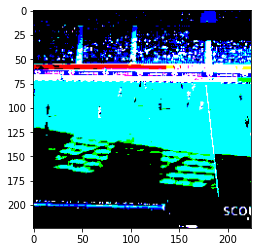

In [41]:
plt.imshow(x[0][0].numpy().transpose(1,2,0))

<All keys matched successfully>

In [12]:
# ===============
# 動画の確認
# ===============    
file_name = '1606b0e6_0.mp4'
id = file_name.replace('.mp4', '')

file_name = INPUT_PATH+f'train/{file_name}'
pic_fname = OUTPUT_PATH + '/' + id + '/tmp.jpg'
video_fname = OUTPUT_PATH + '/' + id + '/tmp.mp4'
os.makedirs(OUTPUT_PATH+'/'+id, exist_ok=True)

cap = cv2.VideoCapture(file_name)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_length = frame_count / fps         # 長さ（秒）を計算する
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

idx = 0
fourcc = cv2.VideoWriter_fourcc(*"VP90")
# save movie
# writer = cv2.VideoWriter(
#     filename=video_fname, 
#     fourcc=fourcc, 
#     fps=int(fps),
#     frameSize=(width, height + 150+len(df_ret)*50),
# )

while True:
    ret, frame = cap.read()
    if not ret:
        break 
    break

In [ ]:
# ===============
# 動画の保存
# ===============  
def save_event_movie(df_rets):
    """
    save 1sec event movies from (event_time - save_sec) to (event_time)
    """

    import math
    frames = 16
    fps = 25
    save_sec = math.ceil(((frames-4)/fps)*10)/10
    save_cnt = int(save_sec * 10)
    save_duration = 1.0
    total = len(df_rets)

    rets = []

    for i, (id, event_time, event) in enumerate(df_rets[['video_id', 'event_time', 'event']].values):

        if i%200==0:
            print(f' ======== now {i} files finished =========')

        file_name = INPUT_PATH+f'train/{id}.mp4'
        os.makedirs(OUTPUT_PATH + '/'+id, exist_ok=True)

        for t in range(save_cnt):
            min_time = event_time - 0.1*t
            max_time = min_time + 1.0
            print(min_time, max_time, event)

            save_path = OUTPUT_PATH + '/'+id+f'/{event}_{min_time:.2f}.mp4'

            ret = {
                "video_id": id,
                "video_path": save_path,
                "start_time": min_time,
                "end_time": max_time,
                "event_time": event_time,
                "event": event,
                }
            rets.append(ret)

            if os.path.exists(save_path):
                continue

            ffmpeg_extract_subclip(file_name, t1=min_time, t2=max_time, targetname=save_path)

    data = pd.DataFrame(rets)
    data.to_csv(OUTPUT_PATH + '/train_data.csv', index=False)

    return data


In [60]:
import glob
from bisect import bisect_left, bisect_right, insort

def save_non_event_movie(movie_path):
    """
    save 1sec event movies from (event_time - save_sec) to (event_time)
    """

    rets = []
    SAVE_PATH = OUTPUT_PATH + '/'+'non_event'
    os.makedirs(SAVE_PATH, exist_ok=True)

    for path in movie_path:
        id = path.split('/')[-1].replace('.mp4', '')
        
        cap = cv2.VideoCapture(path)
        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)# フレーム数を取得する
        fps = cap.get(cv2.CAP_PROP_FPS)          # フレームレートを取得する
        video_length = frames / fps         # 長さ（秒）を計算する
        video_length = int(video_length)

        events = df_rets.query('video_id == @id')['event_time'].values
        events = sorted(events.tolist())

        now = 0

        while now < video_length:

            l = bisect_left(events, now)

            if l==0:
                interval = 10
                pre = -10
                next = events[l]

            elif l==len(events):
                interval = 10
                pre = events[l-1]
                next = 10**9+7
            
            else:
                interval = 1.5
                pre = events[l-1]
                next = events[l]

            if abs(now - pre)<2 or abs(next - now)<2:
                now += interval
                continue

            save_path = SAVE_PATH + '/'+f'{id}_noevent_{now:.2f}.mp4'

            if os.path.exists(save_path):
                now += interval
                continue

            ret = {
                "video_id": id,
                "video_path": save_path,
                "start_time": now,
                "end_time": now+1.0,
                "event_time": -1,
                "event": 'No Event',
                }

            rets.append(ret)

            ffmpeg_extract_subclip(path, t1=now, t2=now+1, targetname=save_path)

            now += interval


    data = pd.DataFrame(rets)
    data.to_csv(OUTPUT_PATH + '/No_event_train_data.csv', index=False)

    return data

In [81]:
# train = save_event_movie(df_rets)

# movie_path = glob.glob(INPUT_PATH + '/train/*.mp4')
# data = save_non_event_movie(movie_path)

In [ ]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

def save_event_movie(df_rets):
    """
    save event movies
    """
    progress = 0
    total = len(df_rets)
    for i, (id, t, event) in enumerate(df_rets[['video_id', 'event_time', 'event']].values):

        if i%400:
            print(f'now {i} files finished')

        file_name = INPUT_PATH+f'train/{id}.mp4'
        os.makedirs(OUTPUT_PATH + '/'+id, exist_ok=True)

        min_time = t - min(tolerances[event])
        max_time = t + min(tolerances[event])
        print(min_time, max_time, event)

        target_name = OUTPUT_PATH + '/'+id+f'/{event}_{t}.mp4'

        ffmpeg_extract_subclip(file_name, t1=min_time, t2=max_time, targetname=target_name)


def save_interval_movie(path):
    """
    save event movies
    """
    cap = cv2.VideoCapture(path)
    frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)# フレーム数を取得する
    fps = cap.get(cv2.CAP_PROP_FPS)          # フレームレートを取得する
    video_length = frames / fps         # 長さ（秒）を計算する
    video_length = int(video_length)
    print(video_length)
    
    id = path.split('/')[-1].replace('.mp4', '')
    
    for i in range(0, video_length, 1):

        if i%100==0:
            print(f'now {i} files finished')

        os.makedirs(OUTPUT_PATH + '/'+id, exist_ok=True)

        min_time = i
        max_time = i + 1

        target_name = OUTPUT_PATH + '/'+id+f'/{i}.mp4'

        ffmpeg_extract_subclip(path, t1=min_time, t2=max_time, targetname=target_name)
        


In [ ]:
# ===============
# 動作確認
# ===============    

# DataLoaderにします
batch_size = 8
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
batch_iterator = iter(val_dataloader)  # イテレータに変換
imgs_transformeds, labels, label_ids, dir_path = next(
    batch_iterator)  # 1番目の要素を取り出す
print(imgs_transformeds.shape)

In [ ]:
# 動作確認
# モデルの用意
net = ECO_2D()
net.train()

# モデルの用意
net = ECO_3D()
net.train()

In [13]:
# 1. tensorboardXの保存クラスを呼び出します
from tensorboardX import SummaryWriter

# 2. フォルダ「tbX」に保存させるwriterを用意します
# フォルダ「tbX」はなければ自動で作成されます
writer = SummaryWriter("./tbX/")

# 3. ネットワークに流し込むダミーデータを作成します
batch_size = 1
dummy_img = torch.rand(batch_size, 16, 96, 28, 28)

# 4. netに対して、ダミーデータである
# dummy_imgを流したときのgraphをwriterに保存させます
writer.add_graph(net, (dummy_img, ))
writer.close()

In [16]:
def create_animation(movie_path):

    cap = cv2.VideoCapture(movie_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    ims = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        ims.append(frame)

    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000 // 24)

target_name = '/content/drive/MyDrive/Competitions/DFL/output/1606b0e6_0/challenge_497.23.mp4'
create_animation(target_name)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
cap = cv2.VideoCapture(target_name)
ret, frame = cap.read()
ret

False

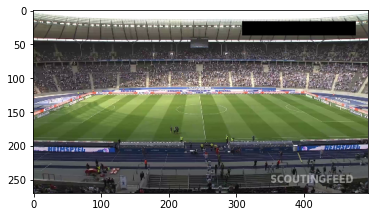

In [76]:
from PIL import Image
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (495, 270))
plt.imshow(img)

In [68]:
frame_count, fps

(89750, 25.0)

## Easy Examples

In [ ]:
# Label data: play(time=1-3), throwin(time=11-13), challenge(time=21-23)
df_case1 = pd.DataFrame({
    "video_id": ["case1"] * 9, 
    "time": [1, 2, 3] + [11, 12, 13] + [21, 22, 23],
    "event": ["start", "play", "end"] + ["start", "challenge", "end"] + ["start", "throwin", "end"]
})
df_case1

,video_id,time,event
0,case1,1,start
1,case1,2,play
2,case1,3,end
3,case1,11,start
4,case1,12,challenge
5,case1,13,end
6,case1,21,start
7,case1,22,throwin
8,case1,23,end


### Prediction test case

## case1. perfect submission

In [ ]:
df_case1.query('event not in ["start", "end"]')

,video_id,time,event
1,case1,2,play
4,case1,12,challenge
7,case1,22,throwin


In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3,
    "time": [2, 12, 22],
    "event": ["play", "challenge", "throwin"],
    "score": [1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12      1     True
1   challenge       0.40    case1    12      1     True
2   challenge       0.50    case1    12      1     True
3   challenge       0.60    case1    12      1     True
4   challenge       0.70    case1    12      1     True
5        play       0.15    case1     2      1     True
6        play       0.20    case1     2      1     True
7        play       0.25    case1     2      1     True
8        play       0.30    case1     2      1     True
9        play       0.35    case1     2      1     True
10    throwin       0.15    case1    22      1     True
11    throwin       0.20    case1    22      1     True
12    throwin       0.25    case1    22      1     True
13    throwin       0.30    case1    22      1     True
14    throwin       0.35    case1    22      1     True
ap_table: 
 event      tolerance
challenge  0.30         1.0
           0.40       

1.0

## case2. predict play -0.3sec

In [ ]:
# Average Precision = (1 + 1 + 0.2) / 3 = 0.7333
#   play: 0.2 (n_prediction=5, n_correct=1(failed to predict torelances [0.15, 0.20, 0.25, 0.30]))
#   challenge: 1
#   throwin: 1

# [Example] In case of event "play" or "throwin", if answer is time=2:
#   get 1.0(5/5) score if you predict play time 1.85 ~ 2.15
#   get 0.8(4/5) score if you predict play time 1.80 ~ 1.85 or 2.15 ~ 2.20
#   get 0.6(3/5) score if you predict play time 1.75 ~ 1.80 or 2.20 ~ 2.25
#   get 0.4(2/5) score if you predict play time 1.70 ~ 1.75 or 2.25 ~ 2.30
#   get 0.2(1/5) score if you predict play time 1.65 ~ 1.70 or 2.30 ~ 2.35
#   get 0.0(0/5) score if you predict play time ~ 1.65 or 2.35 ~

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [1.7, 2.0, 12, 22],
    "event": ["play", "play", "challenge", "throwin"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   1.7      1    False
6        play       0.15    case1   2.0      1     True
7        play       0.20    case1   1.7      1    False
8        play       0.20    case1   2.0      1     True
9        play       0.25    case1   1.7      1    False
10       play       0.25    case1   2.0      1     True
11       play       0.30    case1   1.7      1    False
12       play       0.30    case1   2.0      1     True
13       play       0.35    case1   1.7      1     True
14       play       0.35    case1   2.0      1    False
15    throwin       0.15    case1  22.0      1     True
16    throwin       0.20   

0.8333333333333334

## case3. predict challenge +0.4sec

In [ ]:
# Average Precision = (1 + 1 + 0.6) / 3 = 0.8667
#   play: 1 
#   challenge: 0.6 (n_prediction=5, n_correct=3(failed to predict torelances [0.3, 0.4]))
#   throwin: 1

# [Example] In case of event "challenge", if answer is time=12:
#   get 1.0(5/5) score if you predict play time 11.7 ~ 12.3
#   get 0.8(4/5) score if you predict play time 11.6 ~ 11.7 or 12.3 ~ 12.4
#   get 0.6(3/5) score if you predict play time 11.5 ~ 11.6 or 12.4 ~ 12.5
#   get 0.4(2/5) score if you predict play time 11.4 ~ 11.5 or 12.5 ~ 12.6
#   get 0.2(1/5) score if you predict play time 11.3 ~ 11.4 or 12.6 ~ 12.7
#   get 0.0(0/5) score if you predict play time ~ 11.3 or 12.7 ~

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3,
    "time": [2, 12.4, 22],
    "event": ["play", "challenge", "throwin"],
    "score": [1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.4      1    False
1   challenge       0.40    case1  12.4      1    False
2   challenge       0.50    case1  12.4      1     True
3   challenge       0.60    case1  12.4      1     True
4   challenge       0.70    case1  12.4      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.20    case1   2.0      1     True
7        play       0.25    case1   2.0      1     True
8        play       0.30    case1   2.0      1     True
9        play       0.35    case1   2.0      1     True
10    throwin       0.15    case1  22.0      1     True
11    throwin       0.20    case1  22.0      1     True
12    throwin       0.25    case1  22.0      1     True
13    throwin       0.30    case1  22.0      1     True
14    throwin       0.35    case1  22.0      1     True
ap_table: 
 event      tolerance
challenge  0.30        -0.0
           0.40       

0.8666666666666667

## case4. perfect prediction + out of [start, end] range (time=25, event=play)

In [ ]:
# Only prediction between start and end is evaluated, so this prediction does not affect the score.

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 2.5],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.15    case1   2.5      1    False
7        play       0.20    case1   2.0      1     True
8        play       0.20    case1   2.5      1    False
9        play       0.25    case1   2.0      1     True
10       play       0.25    case1   2.5      1    False
11       play       0.30    case1   2.0      1     True
12       play       0.30    case1   2.5      1    False
13       play       0.35    case1   2.0      1     True
14       play       0.35    case1   2.5      1    False
15    throwin       0.15    case1  22.0      1     True
16    throwin       0.20   

0.8333333333333334

## case5. perfect prediction + miss prediction(event=play, time=12)

In [ ]:
#  Average Precision = (1 + 1 + 0.5) / 3 = 0.8333
#    play: 0.5 (n_prediction=10, n_correct=5(event=play, time=12 is wrong prediction))
#    challenge: 1 
#    throwin: 1

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 12],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12      1     True
1   challenge       0.40    case1    12      1     True
2   challenge       0.50    case1    12      1     True
3   challenge       0.60    case1    12      1     True
4   challenge       0.70    case1    12      1     True
5        play       0.15    case1     2      1     True
6        play       0.15    case1    12      1    False
7        play       0.20    case1     2      1     True
8        play       0.20    case1    12      1    False
9        play       0.25    case1     2      1     True
10       play       0.25    case1    12      1    False
11       play       0.30    case1     2      1     True
12       play       0.30    case1    12      1    False
13       play       0.35    case1     2      1     True
14       play       0.35    case1    12      1    False
15    throwin       0.15    case1    22      1     True
16    throwin       0.20   

0.8333333333333334

## case6. perfect submisson, score = 0.5 for play

In [ ]:
# TODO: add explanation
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3,
    "time": [2, 12, 22],
    "event": ["play", "challenge", "throwin"],
    "score": [0.5, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12    1.0     True
1   challenge       0.40    case1    12    1.0     True
2   challenge       0.50    case1    12    1.0     True
3   challenge       0.60    case1    12    1.0     True
4   challenge       0.70    case1    12    1.0     True
5        play       0.15    case1     2    0.5     True
6        play       0.20    case1     2    0.5     True
7        play       0.25    case1     2    0.5     True
8        play       0.30    case1     2    0.5     True
9        play       0.35    case1     2    0.5     True
10    throwin       0.15    case1    22    1.0     True
11    throwin       0.20    case1    22    1.0     True
12    throwin       0.25    case1    22    1.0     True
13    throwin       0.30    case1    22    1.0     True
14    throwin       0.35    case1    22    1.0     True
ap_table: 
 event      tolerance
challenge  0.30         1.0
           0.40       

1.0

In [ ]:
from sklearn.metrics import precision_recall_curve as prcurve_sklearn
from sklearn.metrics import auc

In [ ]:
np.round(0.344, 2)

0.34

## case7. perfect submisson(score = 0.5 for play) + miss prediction(score=0.25)

# mAPなので確率が上位のものが合っていれば大丈夫。
# ただ、下位まで合わずに外し続けた場合は地獄。

In [ ]:
def prauc(true, pred):
    # for this competition metric
    p = 1  # count of play labels. in this testcase, always 1. This variable is what makes it different from the sklearn precision_recall_curve functions.
    precision, recall, _ = precision_recall_curve(true, pred, p)
    print(precision, recall)
    # for general PRAUC
    # precision, recall, _ = precision_recall_curve(true, pred)
    prauc = auc(recall, precision)
    return prauc

In [ ]:
play_matched = np.array([
    True,  # time = 2
    False  # time = 12
])
play_score = np.array([
    0.5,   # time = 2
    0.75   # time = 12
])
ap_for_play = prauc(play_matched, play_score)
print(f"play_ap = {ap_for_play}, total_ap = {(1 + 1 + ap_for_play) / 3}")

[0.5 0.  1. ] [1. 0. 0.]
play_ap = 0.25, total_ap = 0.75


In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 12],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [0.5, 1, 1, 0.5]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12    1.0     True
1   challenge       0.40    case1    12    1.0     True
2   challenge       0.50    case1    12    1.0     True
3   challenge       0.60    case1    12    1.0     True
4   challenge       0.70    case1    12    1.0     True
5        play       0.15    case1     2    0.5     True
6        play       0.15    case1    12    0.5    False
7        play       0.20    case1     2    0.5     True
8        play       0.20    case1    12    0.5    False
9        play       0.25    case1     2    0.5     True
10       play       0.25    case1    12    0.5    False
11       play       0.30    case1     2    0.5     True
12       play       0.30    case1    12    0.5    False
13       play       0.35    case1     2    0.5     True
14       play       0.35    case1    12    0.5    False
15    throwin       0.15    case1    22    1.0     True
16    throwin       0.20   

0.8333333333333334

## case8 perfect submisson(score = 0.5 for play) + miss prediction(score=0.75)

In [ ]:
play_matched = np.array([
    True,  # time = 2
    False  # time = 12
])
play_score = np.array([
    0.5,   # time = 2
    0.75   # time = 12
])
ap_for_play = prauc(play_matched, play_score)
print(f"play_ap = {ap_for_play}, total_ap = {(1 + 1 + ap_for_play) / 3}")

[0.5 0.  1. ] [1. 0. 0.]
play_ap = 0.25, total_ap = 0.75


In [ ]:
# I expect AP=0.75, but actual AP=0.833. This difference seems to stem from a different way of thinking about the auc function.
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 12],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [0.25, 1, 1, 0.75]
})

event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12   1.00     True
1   challenge       0.40    case1    12   1.00     True
2   challenge       0.50    case1    12   1.00     True
3   challenge       0.60    case1    12   1.00     True
4   challenge       0.70    case1    12   1.00     True
6        play       0.15    case1    12   0.75    False
5        play       0.15    case1     2   0.25     True
8        play       0.20    case1    12   0.75    False
7        play       0.20    case1     2   0.25     True
10       play       0.25    case1    12   0.75    False
9        play       0.25    case1     2   0.25     True
12       play       0.30    case1    12   0.75    False
11       play       0.30    case1     2   0.25     True
14       play       0.35    case1    12   0.75    False
13       play       0.35    case1     2   0.25     True
15    throwin       0.15    case1    22   1.00     True
16    throwin       0.20   

0.8333333333333334

### Explanation between DFL (Average Precision) and Sklearn PRAUC

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as pat

In [ ]:
def auc_dfl(recall, precision):
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])

def auc_sklearn(recall, precision):
    return -np.sum(np.diff(recall) * (precision[:-1] + precision[1:]) / 2)

In [ ]:
# Let's see difference between dfl auc and sklearn auc
recall = np.array([1, 0.5, 0])
precision = np.array([1, 0.75, 0])

In [ ]:
print(f"dfl_auc: {auc_dfl(recall, precision)}, sklearn_auc: {auc_sklearn(recall, precision)}")

dfl_auc: 0.875, sklearn_auc: 0.625


In [ ]:
def draw_pr_curve_auc(xy, title, xy_point):
    # https://python.atelierkobato.com/polygon/
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    p = pat.Polygon(xy=xy, fc="pink", ec="black")
    ax.add_patch(p)
    plt.scatter(xy_point[:, 0], xy_point[:, 1], s=24, color="red", label="pr_point")
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

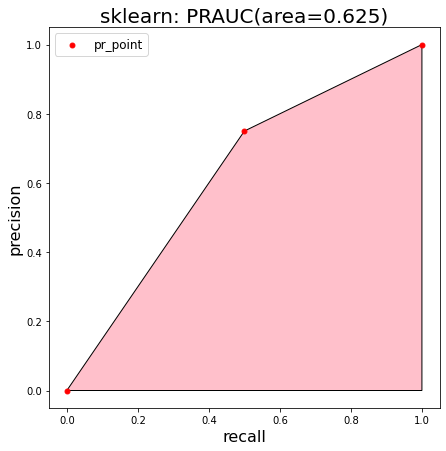

In [ ]:
draw_pr_curve_auc(xy=[(1, 1), (0.5, 0.75), (0, 0), (1, 0)], title=f"sklearn: PRAUC(area={auc_sklearn(recall, precision)})", xy_point=np.array([[1, 1], [0.5, 0.75], [0, 0]]))

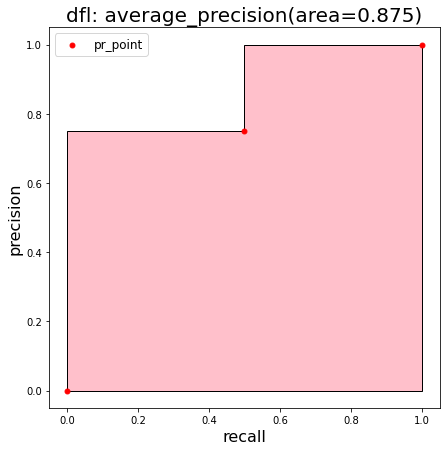

In [ ]:
draw_pr_curve_auc(xy=[(1, 1), (0.5, 1), (0.5, 0.75), (0, 0.75), (0, 0), (1, 0)], title=f"dfl: average_precision(area={auc_dfl(recall, precision)})", xy_point=np.array([[1, 1], [0.5, 0.75], [0, 0]]))

#### If the amount of data is large, maybe the error between the two is slight.

## case9 perfect submisson(score = 0.5 for play) + miss prediction(score=0.25, score=0.75)

In [ ]:
play_matched = np.array([
    True,  # time = 2
    False, # time = 12
    False  # time = 22
])
play_score = np.array([
    0.5,   # time = 2
    0.75,  # time = 12
    0.25,  # time = 22
])
ap_for_play = prauc(play_matched, play_score)
print(f"play_ap = {ap_for_play}, total_ap = {(1 + 1 + ap_for_play) / 3}")

play_ap = 0.25, total_ap = 0.75


In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 5,
    "time": [2, 12, 22, 12, 22],
    "event": ["play", "challenge", "throwin", "play", "play"],
    "score": [0.5, 1, 1, 0.75, 0.25]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12   1.00     True
1   challenge       0.40    case1    12   1.00     True
2   challenge       0.50    case1    12   1.00     True
3   challenge       0.60    case1    12   1.00     True
4   challenge       0.70    case1    12   1.00     True
6        play       0.15    case1    12   0.75    False
5        play       0.15    case1     2   0.50     True
7        play       0.15    case1    22   0.25    False
9        play       0.20    case1    12   0.75    False
8        play       0.20    case1     2   0.50     True
10       play       0.20    case1    22   0.25    False
12       play       0.25    case1    12   0.75    False
11       play       0.25    case1     2   0.50     True
13       play       0.25    case1    22   0.25    False
15       play       0.30    case1    12   0.75    False
14       play       0.30    case1     2   0.50     True
16       play       0.30   

0.8333333333333334

## case10 perfect submisson(score = 0.5 for play) + miss prediction(score=0.65, score=0.75)

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 5,
    "time": [2, 12, 22, 12, 22],
    "event": ["play", "challenge", "throwin", "play", "play"],
    "score": [0.5, 1, 1, 0.75, 0.65]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12   1.00     True
1   challenge       0.40    case1    12   1.00     True
2   challenge       0.50    case1    12   1.00     True
3   challenge       0.60    case1    12   1.00     True
4   challenge       0.70    case1    12   1.00     True
6        play       0.15    case1    12   0.75    False
7        play       0.15    case1    22   0.65    False
5        play       0.15    case1     2   0.50     True
9        play       0.20    case1    12   0.75    False
10       play       0.20    case1    22   0.65    False
8        play       0.20    case1     2   0.50     True
12       play       0.25    case1    12   0.75    False
13       play       0.25    case1    22   0.65    False
11       play       0.25    case1     2   0.50     True
15       play       0.30    case1    12   0.75    False
16       play       0.30    case1    22   0.65    False
14       play       0.30   

0.7777777777777777

## case11 perfect submisson(score=0.5, score=0.55 for play) + miss prediction(score=0.25, score=0.75) 

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 6,
    "time": [2, 12, 22, 12, 22, 2.02],
    "event": ["play", "challenge", "throwin", "play", "play", "play"],
    "score": [0.5, 1, 1, 0.75, 0.25, 0.55]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id   time  score  matched
0   challenge       0.30    case1  12.00   1.00     True
1   challenge       0.40    case1  12.00   1.00     True
2   challenge       0.50    case1  12.00   1.00     True
3   challenge       0.60    case1  12.00   1.00     True
4   challenge       0.70    case1  12.00   1.00     True
6        play       0.15    case1  12.00   0.75    False
8        play       0.15    case1   2.02   0.55     True
5        play       0.15    case1   2.00   0.50    False
7        play       0.15    case1  22.00   0.25    False
10       play       0.20    case1  12.00   0.75    False
12       play       0.20    case1   2.02   0.55     True
9        play       0.20    case1   2.00   0.50    False
11       play       0.20    case1  22.00   0.25    False
14       play       0.25    case1  12.00   0.75    False
16       play       0.25    case1   2.02   0.55     True
13       play       0.25    case1   2.00   0.50    False
15       p

0.8333333333333334

## case12 1 correct and 1 wrong prediction exist in one terms(from start to end)

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 2.5],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.15    case1   2.5      1    False
7        play       0.20    case1   2.0      1     True
8        play       0.20    case1   2.5      1    False
9        play       0.25    case1   2.0      1     True
10       play       0.25    case1   2.5      1    False
11       play       0.30    case1   2.0      1     True
12       play       0.30    case1   2.5      1    False
13       play       0.35    case1   2.0      1     True
14       play       0.35    case1   2.5      1    False
15    throwin       0.15    case1  22.0      1     True
16    throwin       0.20   

0.8333333333333334

## case13 1 correct and 2 wrong predictions exist in one terms(from start to end)

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 5,
    "time": [2, 12, 22, 2.5, 2.6],
    "event": ["play", "challenge", "throwin", "play", "play"],
    "score": [1, 1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.15    case1   2.5      1    False
7        play       0.15    case1   2.6      1    False
8        play       0.20    case1   2.0      1     True
9        play       0.20    case1   2.5      1    False
10       play       0.20    case1   2.6      1    False
11       play       0.25    case1   2.0      1     True
12       play       0.25    case1   2.5      1    False
13       play       0.25    case1   2.6      1    False
14       play       0.30    case1   2.0      1     True
15       play       0.30    case1   2.5      1    False
16       play       0.30   

0.7777777777777777

## case14 perfect predictions 2 times.

In [ ]:
# Only the first predictions is treated as "correct". After the second predicitions, it is treated as "wrong". 
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3 * 2,
    "time": [2, 12, 22] * 2,
    "event": ["play", "challenge", "throwin"] * 2,
    "score": [1, 1, 1] * 2
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12      1     True
1   challenge       0.30    case1    12      1    False
2   challenge       0.40    case1    12      1     True
3   challenge       0.40    case1    12      1    False
4   challenge       0.50    case1    12      1     True
5   challenge       0.50    case1    12      1    False
6   challenge       0.60    case1    12      1     True
7   challenge       0.60    case1    12      1    False
8   challenge       0.70    case1    12      1     True
9   challenge       0.70    case1    12      1    False
10       play       0.15    case1     2      1     True
11       play       0.15    case1     2      1    False
12       play       0.20    case1     2      1     True
13       play       0.20    case1     2      1    False
14       play       0.25    case1     2      1     True
15       play       0.25    case1     2      1    False
16       play       0.30   

0.5

## case15 perfect submission only challenge, throwin
AP achieve 1.0!?<br> 

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 2,
    "time": [12, 22],
    "event": ["challenge", "throwin"],
    "score": [1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0    1.0     True
1   challenge       0.40    case1  12.0    1.0     True
2   challenge       0.50    case1  12.0    1.0     True
3   challenge       0.60    case1  12.0    1.0     True
4   challenge       0.70    case1  12.0    1.0     True
10    throwin       0.15    case1  22.0    1.0     True
11    throwin       0.20    case1  22.0    1.0     True
12    throwin       0.25    case1  22.0    1.0     True
13    throwin       0.30    case1  22.0    1.0     True
14    throwin       0.35    case1  22.0    1.0     True
ap_table: 
 event      tolerance
challenge  0.30         1.0
           0.40         1.0
           0.50         1.0
           0.60         1.0
           0.70         1.0
throwin    0.15         1.0
           0.20         1.0
           0.25         1.0
           0.30         1.0
           0.35         1.0
dtype: float64


1.0

In [ ]:
# you can add example here!